In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt, pylab
from matplotlib import cm
from matplotlib.ticker import LinearLocator

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.

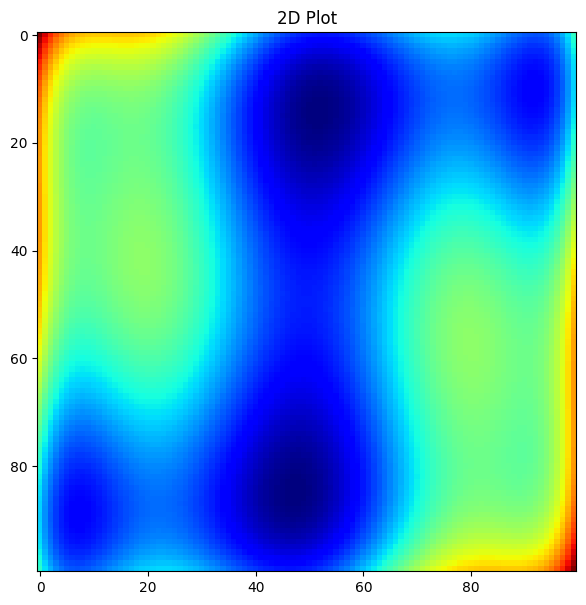

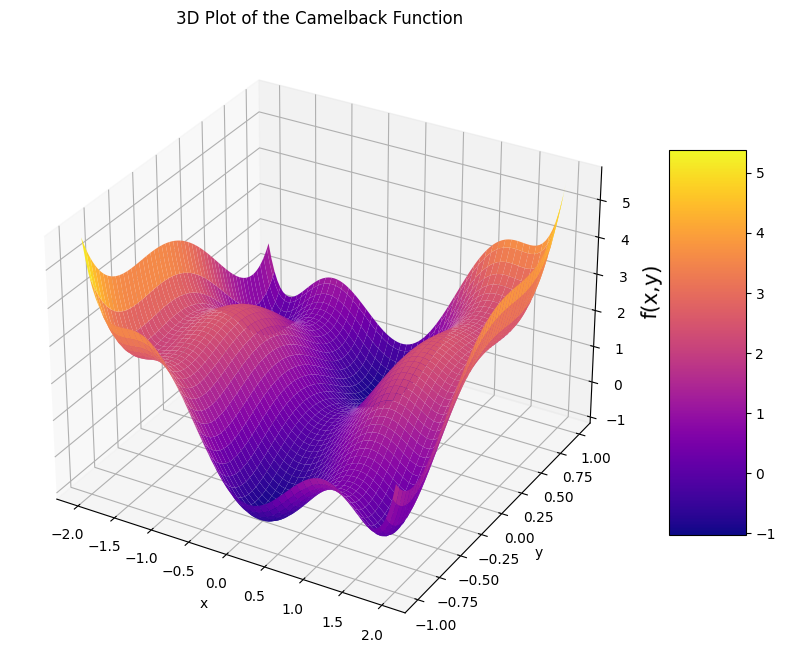

In [2]:
def camelback(x):
    return (4 - 2.1 * (x[0]**2) + (x[0]**4)/3)* x[0]**2 + (x[0]*x[1]) + (4*x[1]**2 - 4)*x[1]**2

x = np.linspace(-2,2,100)
y = np.linspace(-1,1,100)

X, Y = np.meshgrid(x,y)
Z = camelback([X,Y])

plt.figure(figsize= (7,7))
plt2d = plt.imshow(Z, cmap='jet')


plt.title('2D Plot')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_figwidth(10)
fig.set_figheight(10)

surf = ax.plot_surface(X, Y, Z, cmap = cm.plasma, linewidth=0, )

fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('x', fontsize = 10)
ax.set_ylabel('y', fontsize = 10)
ax.set_zlabel('f(x,y)', fontsize = 15)
plt.title('3D Plot of the Camelback Function')
plt.show()

For the initial value of (x,y) = (0,0) we get the value: 0.0
x,y for the above iteration: 0.0 0.0
As the function value does not move from the initial points, this is stagnation point or a saddle point.

For the initial value of (x,y) = (-2,-1) we get the f(x,y) value: -1.0316284534896611
x,y for the above iteration: 0.08984183808297747 -0.7126562831069226

For the initial value of (x,y) = (2,1) we get the f(x,y) value: -1.0316284534896465
x,y for the above iteration: -0.08984185119485916 0.7126562673694432


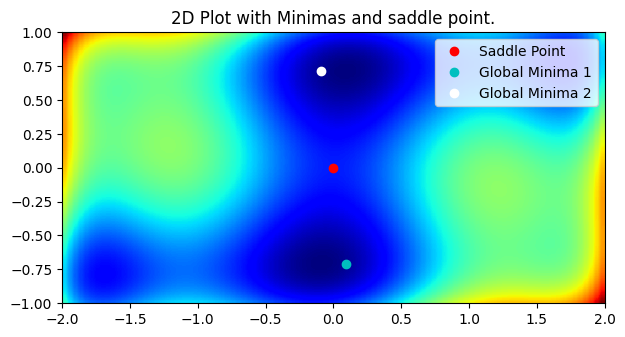

In [3]:
x0 = [0,0]
solution0 = optimize.minimize(camelback, x0)
minx0, miny0 = solution0['x'][0], solution0['x'][1]
print('For the initial value of (x,y) = (0,0) we get the value:',solution0['fun'])
print('x,y for the above iteration:',minx0, miny0)
print('As the function value does not move from the initial points, this is stagnation point or a saddle point.')

x1 = [-2,-1]
solution1 = optimize.minimize(camelback, x1)
minx1, miny1 = solution1['x'][0], solution1['x'][1]
print('\nFor the initial value of (x,y) = (-2,-1) we get the f(x,y) value:',solution1['fun'])
print('x,y for the above iteration:',minx1, miny1)

x2 = [2,1]
solution2 = optimize.minimize(camelback, x2)
minx2, miny2 = solution2['x'][0], solution2['x'][1]
print('\nFor the initial value of (x,y) = (2,1) we get the f(x,y) value:',solution2['fun'])
print('x,y for the above iteration:',minx2, miny2)

x = np.linspace(-2,2,100)
y = np.linspace(-1,1,100)

X, Y = np.meshgrid(x,y)
Z = camelback([X,Y])

plt.figure(figsize= (7,7))
plt2d = plt.imshow(Z, extent=[-2, 2, -1, 1],cmap='jet')
plt.plot(minx0,miny0,'ro', label = 'Saddle Point')
plt.plot(minx1,miny1,'co', label = 'Global Minima 1')
plt.plot(minx2,miny2,'wo', label = 'Global Minima 2')
plt.title('2D Plot with Minimas and saddle point.')
plt.legend()
plt.show()

2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing.

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

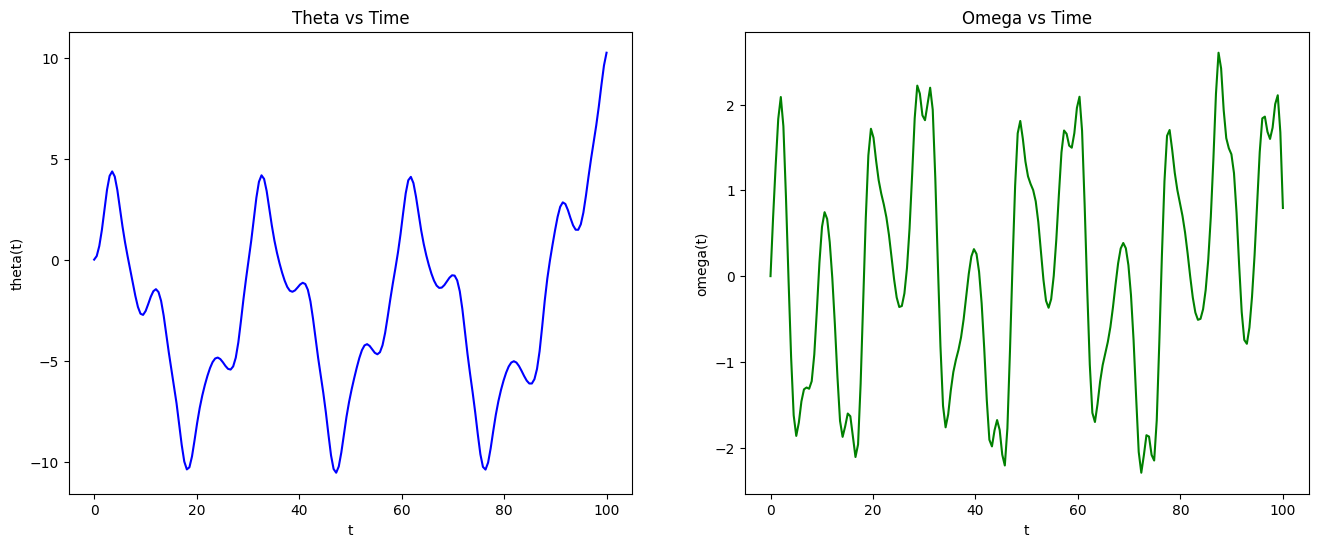

In [4]:
from scipy.integrate import odeint


def derivative(y, time, Q, d, big_omega):
    theta, omega = y
    return [omega, -omega/Q + np.sin(theta) + d*np.cos(big_omega*time)]


#damping factor
Q = 2.0
#forcing amplitude
d = 1.5
steps = 200
#rad/s
big_omega = 0.65

#initial conditions
theta0 = 0.0
omega0 = 0.0

init_vect = [theta0, omega0]

time_vect = np.linspace(0,100,200)

sol = odeint(derivative, init_vect, time_vect, args = (Q,d, big_omega))



fig, (ax1, ax2) = plt.subplots(nrows =1, ncols = 2, figsize = (16,6))
ax1.set_title('Theta vs Time')
ax1.set_xlabel('t')
ax1.set_ylabel('theta(t)')
ax1.plot(time_vect, sol[:, 0], 'b')

ax2.set_title('Omega vs Time')
ax2.set_xlabel('t')
ax2.set_ylabel('omega(t)')
ax2.plot(time_vect, sol[:, 1], 'g')

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`

In [5]:
!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/

--2024-01-15 08:34:13--  https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.13.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.13.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ebe1cnyd2gm836a/populations.txt [following]
--2024-01-15 08:34:14--  https://www.dropbox.com/s/raw/ebe1cnyd2gm836a/populations.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca3bfee7d7798718cf8028b4bc6.dl.dropboxusercontent.com/cd/0/inline/CLY_YxFDZAH4gVH_mTLjK_DNm1D0q7Sf3s7JGmQ31WpAY04UzfV-mVlvYJZoUoW0K5ECb8AGXu5paG47ESxJO2fLDYETOtk-f_d_gKHKoRYx_7gLJZS9eLG6Kh4x2RuyDnY/file# [following]
--2024-01-15 08:34:14--  https://uca3bfee7d7798718cf8028b4bc6.dl.dropboxusercontent.com/cd/0/inline/CLY_YxFDZAH4gVH_mTLjK_DNm1D0q7Sf3s7JGmQ31WpAY04UzfV-mVlvYJZoUoW0K5ECb8AGXu5paG47ESxJO2fLDYETOtk-f_d_gKHKoRYx_7gL

In [6]:
from scipy import fftpack

data = np.loadtxt('data/populations.txt')
year, hares, lynxes, carrots = data.T

df = pd.DataFrame(data)
df

,0,1,2,3
0,1900.0,30000.0,4000.0,48300.0
1,1901.0,47200.0,6100.0,48200.0
2,1902.0,70200.0,9800.0,41500.0
3,1903.0,77400.0,35200.0,38200.0
4,1904.0,36300.0,59400.0,40600.0
5,1905.0,20600.0,41700.0,39800.0
6,1906.0,18100.0,19000.0,38600.0
7,1907.0,21400.0,13000.0,42300.0
8,1908.0,22000.0,8300.0,44500.0
9,1909.0,25400.0,9100.0,42100.0


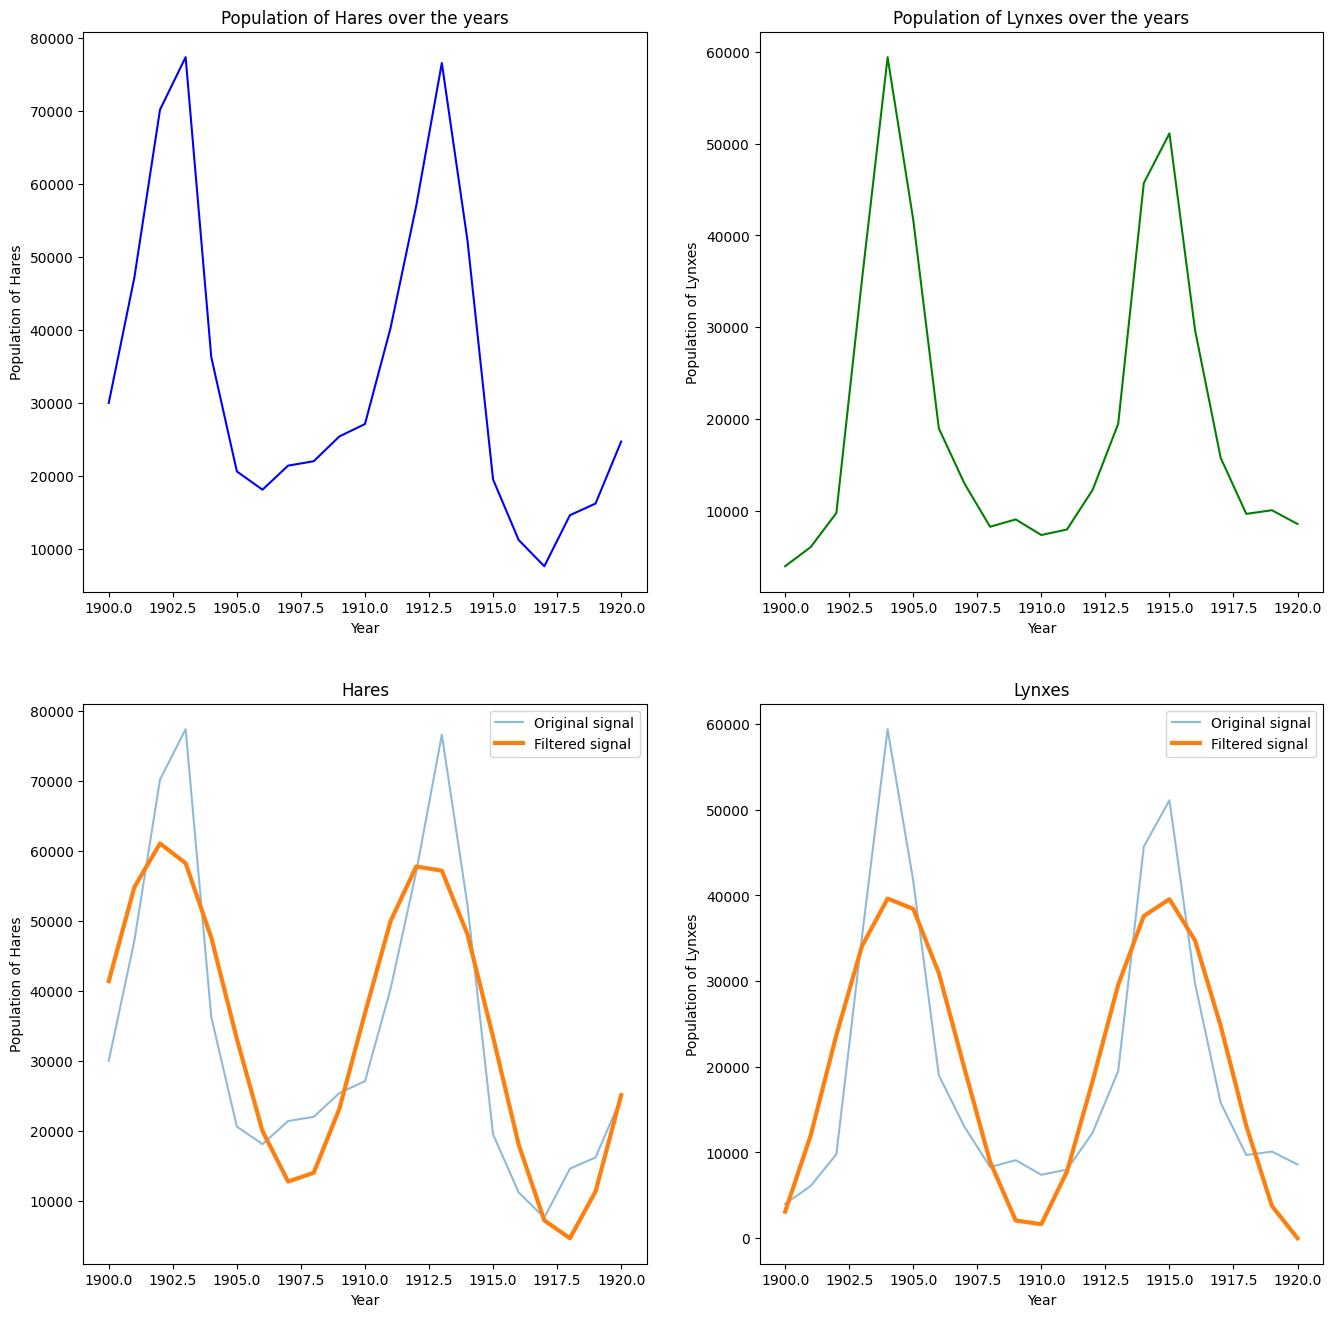

Period of Hares is:  10.5
Period of  Lynxes is:  10.5


In [7]:
hare_fft = fftpack.fft(hares)
lynxes_fft = fftpack.fft(lynxes)

hare_pwr = np.abs(hare_fft)
lynxes_pwr = np.abs(lynxes_fft)

sampling_freq = fftpack.fftfreq(year.size)

mask = np.where(sampling_freq > 0)

freqs = sampling_freq[mask]

peak_h = freqs[hare_pwr[mask].argmax()]
peak_l = freqs[lynxes_pwr[mask].argmax()]

high_freq_h = hare_fft.copy()
high_freq_l = lynxes_fft.copy()

high_freq_h[np.abs(sampling_freq)>peak_h] = 0
high_freq_l[np.abs(sampling_freq)>peak_l] = 0

filtered_h = np.real(fftpack.ifft(high_freq_h))
filtered_l = np.real(fftpack.ifft(high_freq_l))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows =2, ncols = 2, figsize = (16,16))
ax1.set_title('Population of Hares over the years')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population of Hares')
ax1.plot(year, hares, 'b')

ax2.set_title('Population of Lynxes over the years')
ax2.set_xlabel('Year')
ax2.set_ylabel('Population of Lynxes')
ax2.plot(year, lynxes, 'g')


#Plot of the IFFT

ax3.set_title("Hares")
ax3.plot(year, hares, alpha=0.5, label='Original signal')
ax3.plot(year, filtered_h, linewidth=3, label='Filtered signal')
ax3.set_xlabel('Year')
ax3.set_ylabel('Population of Hares')
ax3.legend(loc='best')


ax4.set_title("Lynxes")
ax4.plot(year, lynxes, alpha=0.5, label='Original signal')
ax4.plot(year, filtered_l, linewidth=3, label='Filtered signal')
ax4.set_xlabel('Year')
ax4.set_ylabel('Population of Lynxes')
ax4.legend(loc='best')
plt.show()

print('Period of Hares is: ', 1/peak_h)
print('Period of  Lynxes is: ', 1/peak_l)

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

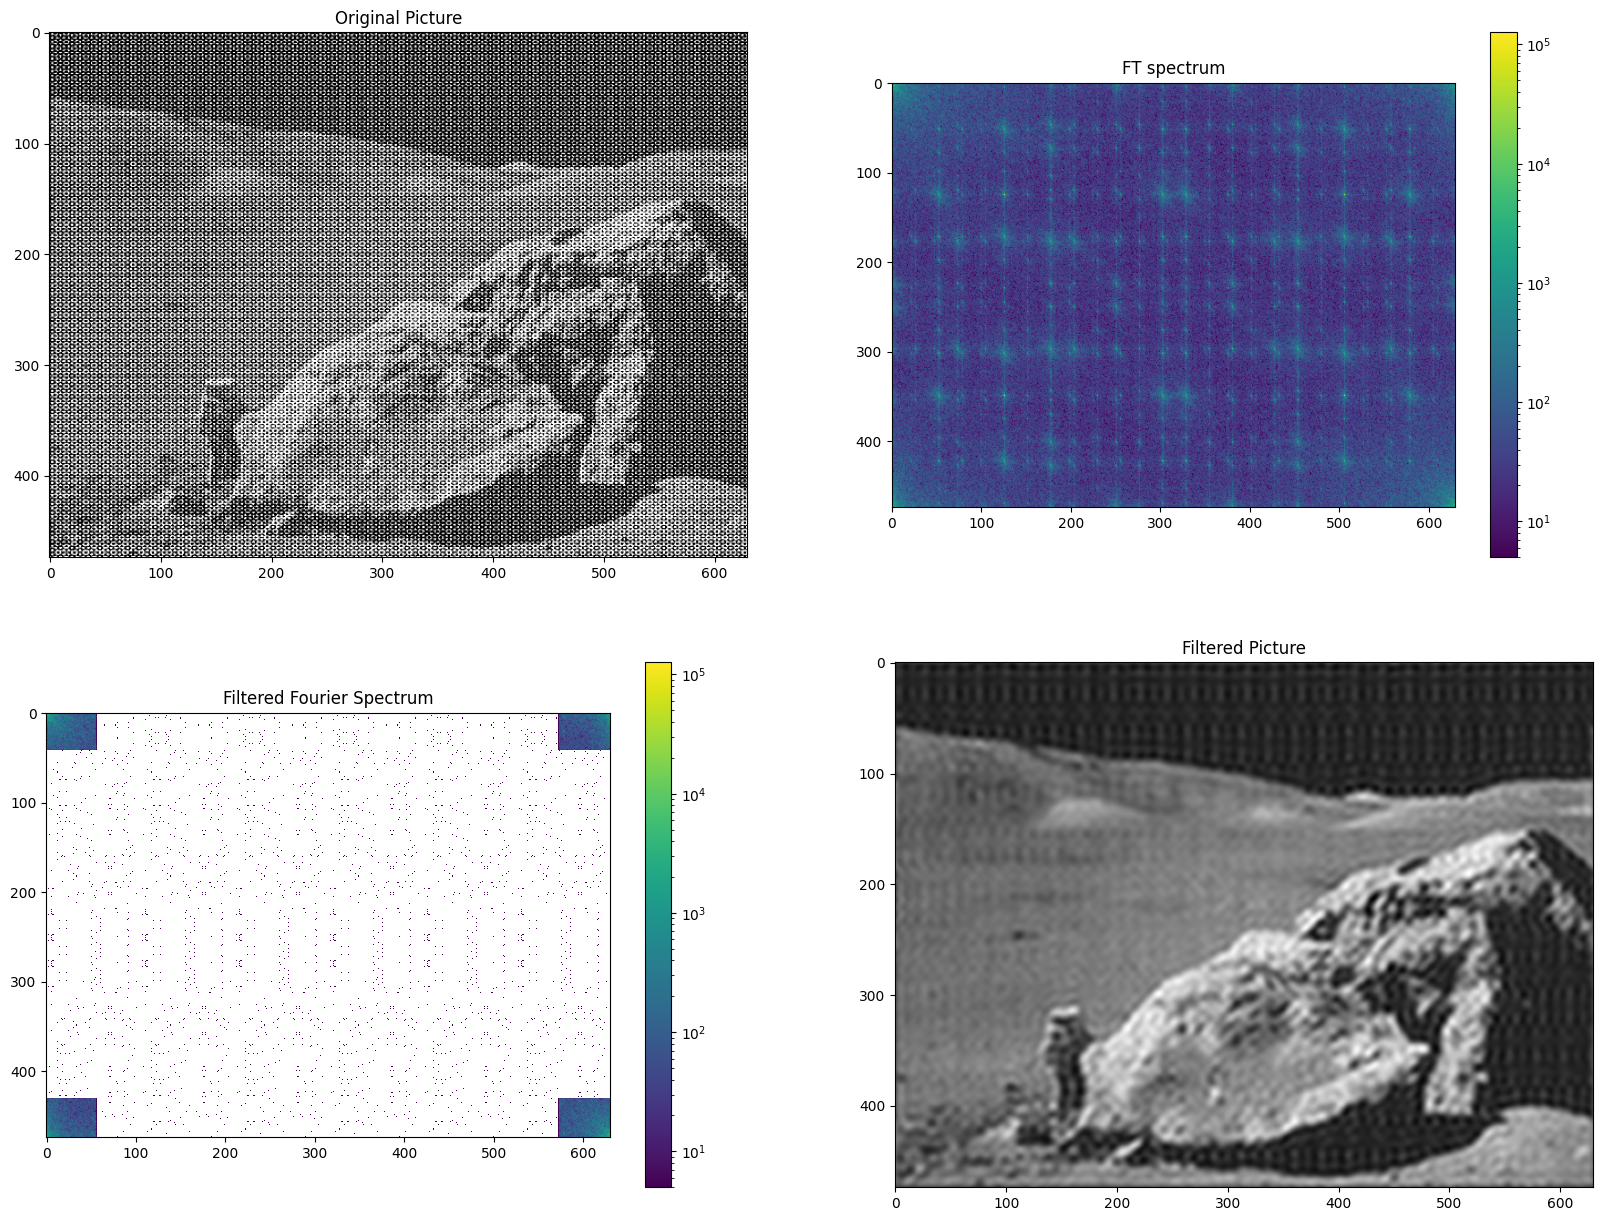

In [8]:
from matplotlib.colors import LogNorm

grid_size = (2, 2)
fig = plt.figure(figsize=(20, 15))

ax1 = plt.subplot2grid(grid_size, (0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid(grid_size, (0, 1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid(grid_size, (1, 0), rowspan=1, colspan=1)
ax4 = plt.subplot2grid(grid_size, (1, 1), rowspan=1, colspan=1)

# real image
ml_image = plt.imread('moonlanding.png')
ax1.imshow(ml_image, plt.cm.gray)
ax1.set_title('Original Picture')

# Fourier transformation
fft_ml = fftpack.fft2(ml_image)

fft_ml_colour = ax2.imshow(np.abs(fft_ml), norm=LogNorm(vmin=5))
plt.colorbar(fft_ml_colour, ax=ax2)
ax2.set_title('FT spectrum')

# fraction of coefficients to keep
coeff_fraction = 0.09

fft_ml2 = fft_ml.copy()
rows, cols = fft_ml2.shape


# De-noising along rows
fft_ml2[int(rows*coeff_fraction):int(rows*(1-coeff_fraction)), :] = 0

# De-noising along columns
fft_ml2[:, int(cols*coeff_fraction):int(cols*(1-coeff_fraction))] = 0

fft_ml2_col=ax3.imshow(np.abs(fft_ml2), norm=LogNorm(vmin=5))
plt.colorbar(fft_ml2_col, ax=ax3)
ax3.set_title('Filtered Fourier Spectrum')


# De-noised Image
image_new = fftpack.ifft2(fft_ml2).real
ax4.imshow(image_new, plt.cm.gray)
ax4.set_title('Filtered Picture')

plt.show()